# **1. Introducción**

Lo más recomendable es usar el entorno de ejecución T4 GPU para ejecutar el trabajo

___
## 1.1 Integrantes

*   Daniel Perea Mercado
*  David Diaz Rodriguez
*  Nicolas Niño Valderrama
*  Valentina Jimenez Torres



___
## 1.2 Descripción del problema del negocio

Hoy en día, los visitantes de parques naturales y jardines botánicos enfrentan dificultades para identificar especies de flores como margaritas, dientes de león, rosas, girasoles y tulipanes. Además, estos espacios, como el Parque Arví y el Jardín Botánico de Medellín, tienen problemas en la gestión de visitantes debido a la cantidad limitada de colaboradores, algunos de los cuales carecen de experiencia en botánica. Esto resulta en una incapacidad para atender la alta demanda de visitantes y convertir sus recorridos en experiencias botánicas satisfactorias.

___
## 1.3 Diseño de solución propuesto

Para abordar el problema expuesto, se propone desarrollar un sistema automatizado de clasificación de especies de flores basado en una Red Neuronal Artificial (ANN). Este modelo será entrenado para identificar, a partir de imágenes, especies como Margarita, Diente de León, Girasol, Rosa y Tulipán. La solución se integrará a una aplicación móvil que permitirá a los usuarios tomar o cargar imágenes, proporcionando una identificación rápida y precisa de las flores.

Se empleará un conjunto de datos de imágenes etiquetadas, adecuadamente preprocesadas para optimizar el rendimiento del modelo. Posteriormente, se implementará la ANN aprovechando su capacidad para reconocer características visuales y patrones complejos. Durante el desarrollo, se ajustarán hiperparámetros clave, y se probarán técnicas de regularización para minimizar el sobreajuste y mejorar la precisión del modelo.

Con esta propuesta, se espera mejorar la experiencia del visitante en parques naturales y jardines botánicos, ofreciendo información adicional sobre las flores. Además, el sistema reducirá los errores humanos en la identificación, optimizará costos asociados al proceso manual y enriquecerá significativamente el recorrido de los usuarios.

___
# **2. Pre procesamiento**

## 2.1 Preparación del notebook

### 2.1.1 Instalación de librerias

In [ ]:
!pip install tensorflow
!pip install keras-tuner

In [ ]:
# import system libraries
import os
import itertools
from PIL import Image
import pathlib
import random
import kagglehub

# import data handling tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# import Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import layers, models
import keras_tuner as kt
from tensorflow import keras
from keras_tuner.tuners import RandomSearch
from tensorflow.keras import regularizers
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Waring Library
import warnings
warnings.filterwarnings('ignore')

___
### 2.1.2 Lectura de datos desde Kaggle

Para este proyecto se hará uso de datos tipo imagen, importados desde el conjunto de datos llamado 'Flowers Dataset' de Kaggle, el cual consiste en imágenes de cinco especie diferentes de flores: Margaritas, Girasoles, Tulipánes, Rosas y Dientes de León.

In [ ]:
# Descargar ultima versión
ruta = kagglehub.dataset_download("rahmasleam/flowers-dataset")
print("Ruta al DataSet:", ruta)

In [ ]:
# En la estructura del dataset, las imágenes están todas dentro de una subcarpeta única (flower_photos),
# y las categorías (como sunflowers, roses, etc.) son subcarpetas dentro de esa.
ruta_categorias = os.path.join(ruta, 'flower_photos')

In [ ]:
# Se descomprimen de las subcarpetas las imagenes y se crea un dataset con cada ruta individual y su
# respectiva categoría

Enlaces, Labels = [], []

#Enlaces: Una lista donde se almacenarán las rutas de cada imagen.
#Labels: Una lista donde se almacenarán las etiquetas asociadas a cada iamgen,
# que serán los nombres de las carpetas.

for categoria in os.listdir(ruta_categorias): #Itera sobre cada subcarpeta dentro de la ruta ruta_categorias
    catpath = os.path.join(ruta_categorias, categoria)
    if os.path.isdir(catpath):  # Verificar que es una carpeta
        Enlaces += [os.path.join(catpath, img) for img in os.listdir(catpath)]
        Labels += [categoria] * len(os.listdir(catpath))

# Crear el dataframe
df = pd.DataFrame({"ruta": Enlaces, "categoría": Labels})

In [ ]:
df.head()

In [ ]:
# Esta es la parte de la ruta que muestra en que subcarpeta esta cada imagen
parte_ruta = df['ruta'].apply(lambda x: x.split('/')[-2])
parte_ruta

In [ ]:
# Verificar si la parte de la ruta donde muestra la subcarpeta de la categoría coincide con la categoría asignada
matchs = df.apply(lambda row: row['ruta'].split('/')[-2] == row['categoría'], axis=1)

# Filtrar las filas donde no coincidan
filas_no_coinciden = df[~matchs]  # '~' invierte la máscara booleana para obtener donde no coinciden
filas_no_coinciden

In [ ]:
# Visualización de las imágenes
num_images = 4 # Número de imágenes por categoría

flower_species = df['categoría'].unique() # Categorías únicas

# Preparar el plot
plt.figure(figsize=(10, 10))

# Recorrer cada categoría de flor
for idx, flower in enumerate(flower_species):
    # Filtra el DataFrame para obtener las rutas de esta especie de flor
    flower_df = df[df['categoría'] == flower].sample(num_images)  # Obtener 16 imágenes aleatorias

    # Recorre las 16 imágenes para mostrarlas
    for i, file in enumerate(flower_df['ruta'].values):
        plt.subplot(len(flower_species), num_images, idx * num_images + i + 1)
        img = Image.open(file)
        plt.imshow(img)
        plt.axis('off')
        plt.title(flower)

# Mostrar las imagenes
plt.tight_layout()
plt.show()

___
## 2.2 Análisis del balanceo entre clases



El accuracy mide la proporción de predicciones correctas entre el total de predicciones:

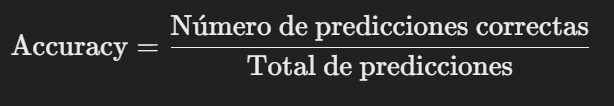

Es adecuado si:

*   Las clases están bien balanceadas (tamaños similares entre todas las clases).
*   No tienes una clase mayoritaria que pueda sesgar el resultado.

Es inadecuado si:

* Hay un gran desequilibrio entre las clases. Por ejemplo, si una clase representa el 90% de los datos, un modelo que predice siempre esa clase puede tener un accuracy alto (90%) sin ser realmente útil.

In [ ]:
df.shape

In [ ]:
df['categoría'].value_counts()

In [ ]:
# Total de imágenes
total = len(df)
# Calcular el porcentaje directamente del total
category_percentages = (df['categoría'].value_counts() / total) * 100

# Mostrar resultados
for category, percentage in category_percentages.items():
    print(f"{category}: {percentage:.2f}%")

Se encuentra necesario balancear las clases para que la métrica tenga un mejor desempeño.

In [ ]:
# Seleccionar aleatoriamente 630 datos de cada categoría
df2 = df.groupby('categoría').apply(lambda x: x.sample(n=630, random_state=123)).reset_index(drop=True)
df2['categoría'].value_counts()

In [ ]:
# Total de imágenes
total = len(df2)
# Calcular el porcentaje directamente del total
category_percentages = (df2['categoría'].value_counts() / total) * 100

# Mostrar resultados
for category, percentage in category_percentages.items():
    print(f"{category}: {percentage:.2f}%")

## 2.3 Separación en entrenamiento, validación y test

In [ ]:
# Separación del dataset

# Crear la variable 'strat' basada en la columna 'categoría'
strat = df2['categoría']

# Configurar proporciones para entrenamiento (70%), validación (20%) y test (10%)
train_size = 0.7
valid_size = 0.2
test_size = 0.1

# Dividir el conjunto inicial en entrenamiento (70%) y "validación+test" (30%)
train_df, temp_df = train_test_split(
    df2,
    test_size=(1 - train_size),
    random_state=123,
    stratify=strat,  # Usar la variable 'strat'
    shuffle=True
)

# Actualizar 'strat' para el conjunto temporal temp_df
strat_temp = temp_df['categoría']

# Dividir el conjunto "validación+test" en validación (20%) y test (10%)
valid_df, test_df = train_test_split(
    temp_df,
    test_size=(test_size / (valid_size + test_size)),  # Ajustar para mantener proporción
    random_state=123,
    stratify=strat_temp  # Usar 'strat_temp' para la segunda división
)

# Mostrar tamaños de los conjuntos
print(f"Tamaño del Dataset Original: {df2.shape[0]}")
print(f"Tamaño del Dataset de Entrenamiento: {len(train_df)}")
print(f"Tamaño del Dataset de Validación: {len(valid_df)}")
print(f"Tamaño del Dataset de Test: {len(test_df)}")

In [ ]:
train_df['categoría'].value_counts()

In [ ]:
# Visualización de las imágenes de entrenamiento
num_images = 4 # Número de imágenes por categoría

flower_species = train_df['categoría'].unique() # Categorías únicas

# Preparar el plot
plt.figure(figsize=(10, 10))

# Recorrer cada categoría de flor
for idx, flower in enumerate(flower_species):
    # Filtra el DataFrame para obtener las rutas de esta especie de flor
    flower_train_df = train_df[train_df['categoría'] == flower].sample(num_images)  # Obtener 16 imágenes aleatorias

    # Recorre las 16 imágenes para mostrarlas
    for i, file in enumerate(flower_train_df['ruta'].values):
        plt.subplot(len(flower_species), num_images, idx * num_images + i + 1)
        img = Image.open(file)
        plt.imshow(img)
        plt.axis('off')
        plt.title(flower)

# Mostrar las imagenes
plt.tight_layout()
plt.show()

In [ ]:
valid_df['categoría'].value_counts()

In [ ]:
# Visualización de las imágenes de validación
num_images = 4 # Número de imágenes por categoría

flower_species = valid_df['categoría'].unique() # Categorías únicas

# Preparar el plot
plt.figure(figsize=(10, 10))

# Recorrer cada categoría de flor
for idx, flower in enumerate(flower_species):
    # Filtra el DataFrame para obtener las rutas de esta especie de flor
    flower_valid_df = valid_df[valid_df['categoría'] == flower].sample(num_images)  # Obtener 16 imágenes aleatorias

    # Recorre las 16 imágenes para mostrarlas
    for i, file in enumerate(flower_valid_df['ruta'].values):
        plt.subplot(len(flower_species), num_images, idx * num_images + i + 1)
        img = Image.open(file)
        plt.imshow(img)
        plt.axis('off')
        plt.title(flower)

# Mostrar las imagenes
plt.tight_layout()
plt.show()

In [ ]:
test_df['categoría'].value_counts()

In [ ]:
# Visualización de las imágenes de testeo
num_images = 4 # Número de imágenes por categoría

flower_species = test_df['categoría'].unique() # Categorías únicas

# Preparar el plot
plt.figure(figsize=(10, 10))

# Recorrer cada categoría de flor
for idx, flower in enumerate(flower_species):
    # Filtra el DataFrame para obtener las rutas de esta especie de flor
    flower_test_df = test_df[test_df['categoría'] == flower].sample(num_images)  # Obtener 16 imágenes aleatorias

    # Recorre las 16 imágenes para mostrarlas
    for i, file in enumerate(flower_test_df['ruta'].values):
        plt.subplot(len(flower_species), num_images, idx * num_images + i + 1)
        img = Image.open(file)
        plt.imshow(img)
        plt.axis('off')
        plt.title(flower)

# Mostrar las imagenes
plt.tight_layout()
plt.show()

___
## 2.4 Estandarización y generación de los datos

In [ ]:
# Parámetros
batch_size = 32 # Tamaño del lote que será cargado por el generador en cada iteración.
img_size = (128, 128) # Dimensiones a las que se redimensionan las imágenes (128x128 píxeles).
channels = 3 # RGB
# Forma final de las imágenes después del preprocesamiento (128x128x3).

# Generador con Data Augmentation en el conjunto de entrenamiento para aumentar la diversidad
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalización de píxeles a [0, 1]
    rotation_range=30,  # Rotación aleatoria en grados
    width_shift_range=0.2,  # Desplazamiento horizontal
    height_shift_range=0.2,  # Desplazamiento vertical
    shear_range=0.2,  # Transformación de corte
    zoom_range=0.2,  # Zoom aleatorio
    horizontal_flip=True,  # Volteo horizontal
    fill_mode='nearest')  # Relleno de píxeles fuera del límite


# Generador para validación y prueba (sin aumentación, solo normalización)
valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Carga y estandarización de datos
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='ruta',
    y_col='categoría',
    target_size=img_size,
    class_mode='categorical', # One-Hot Encoding para las categoría de las flores
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size)

valid_gen = valid_test_datagen.flow_from_dataframe(
    valid_df,
    x_col='ruta',
    y_col='categoría',
    target_size=img_size,
    class_mode='categorical',  # Esto convierte automáticamente las etiquetas de texto en vectores One-Hot.
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size)

test_gen = valid_test_datagen.flow_from_dataframe(
    test_df,
    x_col='ruta',
    y_col='categoría',
    target_size=img_size,
    class_mode='categorical',  # Esto convierte automáticamente las etiquetas de texto en vectores One-Hot.
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size)

In [ ]:
# Visualización de las imáganes de data aumentada

# Número de imágenes por categoría
num_images = 4

# Obtener las clases (categorías) desde el generador
class_indices = train_gen.class_indices
classes = list(class_indices.keys())  # Lista de categorías únicas

# Configurar el tamaño del plot
plt.figure(figsize=(15, len(classes) * 3))

# Visualizar imágenes por cada categoría
for idx, flower in enumerate(classes):
    count = 0  # Contador para limitar las imágenes a num_images
    while count < num_images:
        # Obtener un batch de imágenes y etiquetas
        images, labels = next(train_gen)

        # Filtrar las imágenes que pertenecen a la categoría actual
        for i in range(len(labels)):
            if np.argmax(labels[i]) == idx:  # Coincide con la categoría actual
                plt.subplot(len(classes), num_images, idx * num_images + count + 1)
                plt.imshow(images[i])
                plt.axis('off')
                plt.title(flower)
                count += 1

                # Si ya tenemos suficientes imágenes para esta categoría, salir del loop
                if count == num_images:
                    break

# Mostrar las imágenes
plt.tight_layout()
plt.show()

___
# **3. Desarrollo red neuronal convolucional CNN**

## 3.1 Arquitectura base

In [ ]:
# Definición de la arquitectura CNN base
model = models.Sequential()

# Primera capa convolucional
model.add(
    layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides=(1, 1),  # Strides más pequeños para preservar información
        activation='relu',
        input_shape=(128, 128, 3)))

model.add(
    layers.MaxPooling2D(
        pool_size=(2, 2)))  # Primera reducción de dimensionalidad

# Segunda capa convolucional
model.add(
    layers.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides=(1, 1),  # Strides pequeños
        activation='relu'))

model.add(
    layers.MaxPooling2D(
        pool_size=(2, 2)))  # Segunda reducción

# Tercera capa convolucional
model.add(
    layers.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides=(1, 1),
        activation='relu'))

model.add(
    layers.MaxPooling2D(
        pool_size=(2, 2)))  # Tercera reducción

# Aplanar para conectar con las capas densas
model.add(layers.Flatten())

# Primera capa densa
model.add(
    layers.Dense(
        units=128,
        activation='relu'))

# Segunda capa densa
model.add(
    layers.Dense(
        units=32,
        activation='relu'))

# Capa de salida
model.add(
    layers.Dense(
        units=5,
        activation='softmax'))

In [ ]:
# Compilador
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

In [ ]:
# Representación esquemática de la arquitectura, para entender mejor la arquitectura de la red neorunal.
keras.utils.plot_model(
    model, #parametro a graficar
    to_file = 'model.png', # nombre de la imagen
    show_shapes = True, # mostrar figuras
    show_layer_names = True) # mostrar nombres de las capas

In [ ]:
# Entrenamos la red neuronal convolucional
history = model.fit(
    train_gen,
    epochs=50,
    validation_data=valid_gen,
    verbose=1)

In [ ]:
# Visualización de las curvas de error
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perdida del modelo')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
# Visualización de las curvas de accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy del modelo')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])
plt.show()

## 3.2 Optimización de hiperparámetros

In [ ]:
# Definición de la arquitectura CNN base como un HyperModel
def build_model(hp):
    model = keras.Sequential()

    # Definición de la primera capa convolucional con optimización de hiperparámetros
    model.add(
        keras.layers.Conv2D(
            filters = hp.Int('filters_1', min_value=16, max_value=256, step=16),
            kernel_size = hp.Choice('kernel_size_1', values = [3, 5]),
            strides=(1, 1),
            activation = 'relu',
            input_shape=(128, 128, 3)))

    model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    # Definición de la segunda capa convolucional con optimización de hiperparámetros
    model.add(
        keras.layers.Conv2D(
            filters = hp.Int('filters_2', min_value=16, max_value=256, step=16),
            kernel_size = hp.Choice('kernel_size_2', values = [3, 5]),
            strides=(1, 1),
            activation = 'relu'))

    model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    # Definición de la tercera capa convolucional con optimización de hiperparámetros
    model.add(
        keras.layers.Conv2D(
            filters = hp.Int('filters_3', min_value=16, max_value=256, step=16),
            kernel_size = hp.Choice('kernel_size_3', values = [3, 5]),
            strides=(1, 1),
            activation = 'relu'))

    model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    # Aplanar el tensor 2D a 1D
    model.add(keras.layers.Flatten())

    # Adición de la primera capa oculta con optimización de hiperparámetros
    model.add(
        keras.layers.Dense(
            units = hp.Int('units_1', min_value=32, max_value=256, step=16),
            activation = hp.Choice('activation_d1', values=['relu', 'tanh'])))

    # Adición de la segunda capa oculta con optimización de hiperparámetros
    model.add(
        keras.layers.Dense(
            units = hp.Int('units_2', min_value=32, max_value=256, step=16),
            activation = hp.Choice('activation_d2', values=['relu', 'tanh'])))

    # Definición de la capa de salida
    model.add(
        keras.layers.Dense(
            units=5,
            activation='softmax'))

    # Definición del compilador con optimización del hiperparámetro learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001, 0.00001])
    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss = 'categorical_crossentropy',  # Las etiquetas están one-hot encoded
        metrics = ['accuracy'])

    return model

In [ ]:
# Configuración del tuner para la búsqueda de hiperparámetros utilizando RandomSearch
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=6,
    executions_per_trial=2,
    directory='results_tuner',
    project_name='cnn_tuning')

# Realización de la búsqueda de los mejores hiperparámetros
tuner.search(train_gen, epochs=7, validation_data=valid_gen)

In [ ]:
# Mostrar el mejor modelo obtenido en la búsqueda
for h_param in [f'filters_{i}' for i in [1,2,3]] + [f'kernel_size_{i}' for i in [1,2,3]] + [f"units_{i}" for i in [1,2]] + [f"activation_d{i}" for i in [1,2]] + ['learning_rate']:
  print(f"{h_param}: {tuner.get_best_hyperparameters()[0].get(h_param)}")

In [ ]:
# Guardar los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
#Obtención del modelo con mejores hiperparámetros
model = tuner.hypermodel.build(best_hps)
model.summary()

In [ ]:
# Entrenamiento del modelo con los mejores hiperparámetros
history2 = model.fit(train_gen, epochs=50, validation_data=valid_gen)

In [ ]:
# Visualización de las curvas de error
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Perdida del modelo')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
# Visualización de las curvas de accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Accuracy del modelo')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])
plt.show()

## 3.3 Regularización

Debido al sobreajuste del modelo se hace necesario realizar la regularización

### 3.3.1 CNN con Dropout

In [ ]:
# Optimización de hiperparámetro para Dropout utilizando los hiperparametros anteriormente encontrados

def build_model_dropout(hp):

    model_dropout = keras.Sequential()

    # Primera capa convolucional
    model_dropout.add(
        layers.Conv2D(
            filters=best_hps.get('filters_1'),
            kernel_size=(best_hps.get('kernel_size_1'),best_hps.get('kernel_size_1')),
            strides=(1, 1),
            activation='relu',
            input_shape=(128, 128, 3)))

    model_dropout.add(
        layers.MaxPooling2D(
            pool_size=(2, 2)))  # Primera reducción de dimensionalidad

    # Primera capa de dropout
    model_dropout.add(keras.layers.Dropout(hp.Float('dropout_rate_1',
                                                    min_value= 0.1,
                                                    max_value= 0.5,
                                                    step=0.1)))

    # Segunda capa convolucional
    model_dropout.add(
        layers.Conv2D(
            filters=best_hps.get('filters_2'),
            kernel_size=(best_hps.get('kernel_size_2'),best_hps.get('kernel_size_2')),
            strides=(1, 1),
            activation='relu'))

    model_dropout.add(
        layers.MaxPooling2D(
            pool_size=(2, 2)))  # Segunda reducción

    # Segunda capa de dropout
    model_dropout.add(keras.layers.Dropout(hp.Float('dropout_rate_2',
                                                    min_value= 0.1,
                                                    max_value= 0.5,
                                                    step=0.1)))

    # Tercera capa convolucional
    model_dropout.add(
        layers.Conv2D(
            filters=best_hps.get('filters_3'),
            kernel_size=(best_hps.get('kernel_size_3'),best_hps.get('kernel_size_3')),
            strides=(1, 1),
            activation='relu'))

    model_dropout.add(
        layers.MaxPooling2D(
            pool_size=(2, 2)))  # Tercera reducción

    # Tercera capa de dropout
    model_dropout.add(keras.layers.Dropout(hp.Float('dropout_rate_3',
                                                    min_value= 0.1,
                                                    max_value= 0.5,
                                                    step=0.1)))

    # Capa de Flatten para convertir a 1D
    model_dropout.add(layers.Flatten())

    # Primera capa densa con Dropout
    model_dropout.add(
        layers.Dense(
            units=best_hps.get('units_1'),
            activation=best_hps.get('activation_d1')))

    # Segunda capa densa
    model_dropout.add(
        layers.Dense(
            units=best_hps.get('units_2'),
            activation=best_hps.get('activation_d2')))

    # Cuarta capa de dropout
    model_dropout.add(keras.layers.Dropout(hp.Float('dropout_rate_4',
                                                    min_value= 0.1,
                                                    max_value= 0.5,
                                                    step=0.1)))

    # Capa de salida
    model_dropout.add(
        layers.Dense(
            units=5,
            activation='softmax'))

    model_dropout.compile(
        optimizer = keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model_dropout

In [ ]:
# Configuración del tuner para la búsqueda de hiperparámetros utilizando RandomSearch
tuner = RandomSearch(
    build_model_dropout,
    objective='val_accuracy',
    max_trials=6,
    executions_per_trial=2,
    directory='results_tuner',
    project_name='cnn_tuning_dropout')

# Realización de la búsqueda de los mejores hiperparámetros
tuner.search(train_gen, epochs=7, validation_data=valid_gen)

In [ ]:
# Mostrar el mejor modelo obtenido en la búsqueda
for h_param in [f'dropout_rate_{i}' for i in range(1,5)]:
  print(f"{h_param}: {tuner.get_best_hyperparameters()[0].get(h_param)}")

In [ ]:
# Guardar los mejores hiperparámetros
best_hps_dropout = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
#Obtención del modelo con mejores hiperparámetros
model_dropout = tuner.hypermodel.build(best_hps_dropout)
model_dropout.summary()

In [ ]:
# Entrenamiento del modelo con los mejores hiperparámetros con dropout
history3 = model_dropout.fit(train_gen, epochs=50, validation_data=valid_gen)

In [ ]:
# Visualización de las curvas de error
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Perdida del modelo')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
# Visualización de las curvas de accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Accuracy del modelo')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])
plt.show()

### 3.3.2 CNN con L2

L2 sólo enel modelo antes de Dropout

In [ ]:
model_l2_before = models.Sequential()

# Primera capa convolucional con L2
model_l2_before.add(
    layers.Conv2D(
        filters=best_hps.get('filters_1'),
        kernel_size=(best_hps.get('kernel_size_1'), best_hps.get('kernel_size_1')),
        strides=(1, 1),
        activation='relu',
        kernel_regularizer=regularizers.L2(0.01),  # Regularización L2
        input_shape=(128, 128, 3)))

model_l2_before.add(
    layers.MaxPooling2D(
        pool_size=(2, 2)))  # Primera reducción de dimensionalidad

# Segunda capa convolucional con L2
model_l2_before.add(
    layers.Conv2D(
        filters=best_hps.get('filters_2'),
        kernel_size=(best_hps.get('kernel_size_2'), best_hps.get('kernel_size_2')),
        strides=(1, 1),
        activation='relu',
        kernel_regularizer=regularizers.L2(0.01)))

model_l2_before.add(
    layers.MaxPooling2D(
        pool_size=(2, 2)))  # Segunda reducción

# Tercera capa convolucional con L2
model_l2_before.add(
    layers.Conv2D(
        filters=best_hps.get('filters_3'),
        kernel_size=(best_hps.get('kernel_size_3'), best_hps.get('kernel_size_3')),
        strides=(1, 1),
        activation='relu',
        kernel_regularizer=regularizers.L2(0.01)))

model_l2_before.add(
    layers.MaxPooling2D(
        pool_size=(2, 2)))  # Tercera reducción

# Capa de Flatten para convertir a 1D
model_l2_before.add(layers.Flatten())

# Primera capa densa con L2
model_l2_before.add(
    layers.Dense(
        units=best_hps.get('units_1'),
        activation=best_hps.get('activation_d1'),
        kernel_regularizer=regularizers.L2(0.01)))

# Segunda capa densa con L2
model_l2_before.add(
    layers.Dense(
        units=best_hps.get('units_2'),
        activation=best_hps.get('activation_d2'),
        kernel_regularizer=regularizers.L2(0.01)))

# Capa de salida
model_l2_before.add(
    layers.Dense(
        units=5,
        activation='softmax'))

In [ ]:
model_l2_before.compile(
    optimizer = keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model_l2_before.summary()

In [ ]:
# Entrenamos la red neuronal convolucional
history4 = model_l2_before.fit(
    train_gen,
    epochs=50,
    validation_data=valid_gen,
    verbose=1)

In [ ]:
# Visualización de las curvas de error
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Perdida del modelo')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
# Visualización de las curvas de accuracy
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Accuracy del modelo')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])
plt.show()

### 3.3.2 CNN con Dropout y L2

In [ ]:
model_l2_dp = models.Sequential()

# Primera capa convolucional con L2
model_l2_dp.add(
    layers.Conv2D(
        filters=best_hps.get('filters_1'),
        kernel_size=(best_hps.get('kernel_size_1'), best_hps.get('kernel_size_1')),
        strides=(1, 1),
        activation='relu',
        kernel_regularizer=regularizers.L2(0.001),  # Regularización L2
        input_shape=(128, 128, 3)))

model_l2_dp.add(
    layers.MaxPooling2D(
        pool_size=(2, 2)))  # Primera reducción de dimensionalidad

# Primera capa de dropout
model_l2_dp.add(keras.layers.Dropout(best_hps_dropout.get('dropout_rate_1')))

# Segunda capa convolucional con L2
model_l2_dp.add(
    layers.Conv2D(
        filters=best_hps.get('filters_2'),
        kernel_size=(best_hps.get('kernel_size_2'), best_hps.get('kernel_size_2')),
        strides=(1, 1),
        activation='relu'))

model_l2_dp.add(
    layers.MaxPooling2D(
        pool_size=(2, 2)))  # Segunda reducción

# Segunda capa de dropout
model_l2_dp.add(keras.layers.Dropout(best_hps_dropout.get('dropout_rate_2')))

# Tercera capa convolucional con L2
model_l2_dp.add(
    layers.Conv2D(
        filters=best_hps.get('filters_3'),
        kernel_size=(best_hps.get('kernel_size_3'), best_hps.get('kernel_size_3')),
        strides=(1, 1),
        activation='relu',
        kernel_regularizer=regularizers.L2(0.01)))

model_l2_dp.add(
    layers.MaxPooling2D(
        pool_size=(2, 2)))  # Tercera reducción

# Tercera capa de dropout
model_l2_dp.add(keras.layers.Dropout(best_hps_dropout.get('dropout_rate_3')))

# Capa de Flatten para convertir a 1D
model_l2_dp.add(layers.Flatten())

# Primera capa densa con L2
model_l2_dp.add(
    layers.Dense(
        units=best_hps.get('units_1'),
        activation=best_hps.get('activation_d1')))

# Segunda capa densa con L2
model_l2_dp.add(
    layers.Dense(
        units=best_hps.get('units_2'),
        activation=best_hps.get('activation_d2'),
        kernel_regularizer=regularizers.L2(0.01)))

# Cuarta capa de dropout
model_l2_dp.add(keras.layers.Dropout(best_hps_dropout.get('dropout_rate_4')))

# Capa de salida
model_l2_dp.add(
    layers.Dense(
        units=5,
        activation='softmax'))

In [ ]:
model_l2_dp.compile(
    optimizer = keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model_l2_dp.summary()

In [ ]:
# Entrenamos la red neuronal convolucional
history5 = model_l2_dp.fit(
    train_gen,
    epochs=50,
    validation_data=valid_gen,
    verbose=1)

In [ ]:
# Visualización de las curvas de error
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Perdida del modelo')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
# Visualización de las curvas de accuracy
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('Accuracy del modelo')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])
plt.show()

# **4. Elección del modelo**



Se evaluaron cinco configuraciones diferentes de una red neuronal convolucional (CNN) para determinar la estrategia de optimización y regularización más efectiva. Las configuraciones incluyeron una CNN base, una CNN con optimización de hiperparámetros, una CNN con regularización por dropout, una CNN con regularización por L2, y una CNN con una combinación de dropout y L2.

La CNN base mostró una alta precisión en el conjunto de entrenamiento, pero un rendimiento significativamente peor en el conjunto de validación, acompañado de una pérdida de validación creciente al final del entrenamiento. Este comportamiento sugiere un problema de sobreajuste, donde el modelo memoriza los datos de entrenamiento, resultando en una baja capacidad de generalización a nuevos datos. Con la optimización de hiperparámetros, se observó una mejora en la precisión tanto en el entrenamiento como en la validación. Además, la pérdida de validación mostró una tendencia más estable en comparación con la CNN base. Ajustar los hiperparámetros clave ayudó a encontrar un equilibrio adecuado entre el sesgo y la varianza, mejorando la robustez del modelo y su capacidad de generalización.

La introducción de dropout resultó en una precisión de entrenamiento menor que en los modelos anteriores, pero la precisión de validación fue comparable y la pérdida de validación disminuyó significativamente. Dropout ayudó a reducir el sobreajuste, mejorando la capacidad del modelo para generalizar a datos nuevos, aunque la precisión de entrenamiento fue menor debido a la regularización. Por otro lado, la regularización L2 mejoró la precisión de validación y mostró una tendencia más estable en la pérdida de validación en comparación con los modelos anteriores. La regularización L2 ayudó a limitar la complejidad del modelo, reduciendo el sobreajuste y mejorando la capacidad de generalización a datos nuevos.

Finalmente, la combinación de dropout y L2 resultó en la mejor precisión de validación y una pérdida de validación que disminuyó de manera constante. Combinar ambas técnicas de regularización aprovechó las fortalezas de cada una, resultando en un modelo robusto y simple con la mejor capacidad de generalización entre todas las configuraciones evaluadas.

Se concluye que, la CNN con la combinación de regularización por dropout y L2 mostró el mejor rendimiento en términos de capacidad de generalización y estabilidad. Esta configuración balancea eficientemente el aprendizaje del modelo con la prevención del sobreajuste, siendo la elección más adecuada para el problema planteado.

In [ ]:
# Evaluar la red neuronal en el conjunto de prueba
test_loss, test_acc = model_l2_dp.evaluate(test_gen)

# Imprimir los resultados
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')